# VAE

Variational Autoencoders (VAEs) are a type of generative model that learn to capture the underlying distribution of a dataset. They are particularly useful for modeling complex data such as images or text. VAEs are based on the concept of autoencoders, which are neural networks that learn to encode and decode data.

An autoencoder consists of two main components: an encoder and a decoder. The encoder takes an input data point and maps it to a lower-dimensional representation called the latent space. The decoder, on the other hand, takes a point in the latent space and reconstructs the original input data. The encoder and decoder are trained together in an unsupervised manner to minimize the reconstruction error, aiming to reconstruct the input data as accurately as possible.

What sets VAEs apart from traditional autoencoders is their probabilistic nature. VAEs model the latent space as a probability distribution, typically a multivariate Gaussian distribution. This probabilistic interpretation allows VAEs to learn more flexible and expressive latent representations.

During training, VAEs not only aim to reconstruct the input data accurately but also to match the learned distribution of the latent space to a desired prior distribution, usually a standard Gaussian distribution. This is achieved by introducing a regularization term called the Kullback-Leibler (KL) divergence, which measures the difference between the learned distribution and the desired prior distribution.

By optimizing the reconstruction error and the KL divergence simultaneously, VAEs learn to generate new data points by sampling from the learned latent space distribution. This enables the generation of new and realistic data samples that resemble the training data.

One of the key advantages of VAEs is their ability to perform latent space interpolation. By linearly interpolating between two points in the latent space and decoding the interpolated points, we can generate new data samples that smoothly transition between the corresponding samples in the input space. This property allows VAEs to explore the underlying structure of the data and generate meaningful variations.

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the variational autoencoder architecture
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
        )

        self.mean = nn.Linear(256, 2)
        self.logvar = nn.Linear(256, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std

        decoded = self.decoder(z)
        return decoded, mean, logvar


In [2]:

# Load the MNIST dataset
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Create an instance of the variational autoencoder model
vae = VariationalAutoencoder()

# Define the loss function and optimizer
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Train the variational autoencoder
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        images, _ = data
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        outputs, mean, logvar = vae(images)

        # Compute reconstruction loss
        reconstruction_loss = criterion(outputs, images)

        # Compute KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader)}")


100%|██████████| 9912422/9912422 [00:00<00:00, 119711922.45it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8381932.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28689026.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13997449.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 25059.37525819563
Epoch 2/10, Loss: 21855.93986748734
Epoch 3/10, Loss: 21171.954707489338
Epoch 4/10, Loss: 20814.680934751465
Epoch 5/10, Loss: 20576.895501565832
Epoch 6/10, Loss: 20398.878770905518
Epoch 7/10, Loss: 20252.7305416278
Epoch 8/10, Loss: 20133.942851312633
Epoch 9/10, Loss: 20023.200626332622
Epoch 10/10, Loss: 19935.12286155717


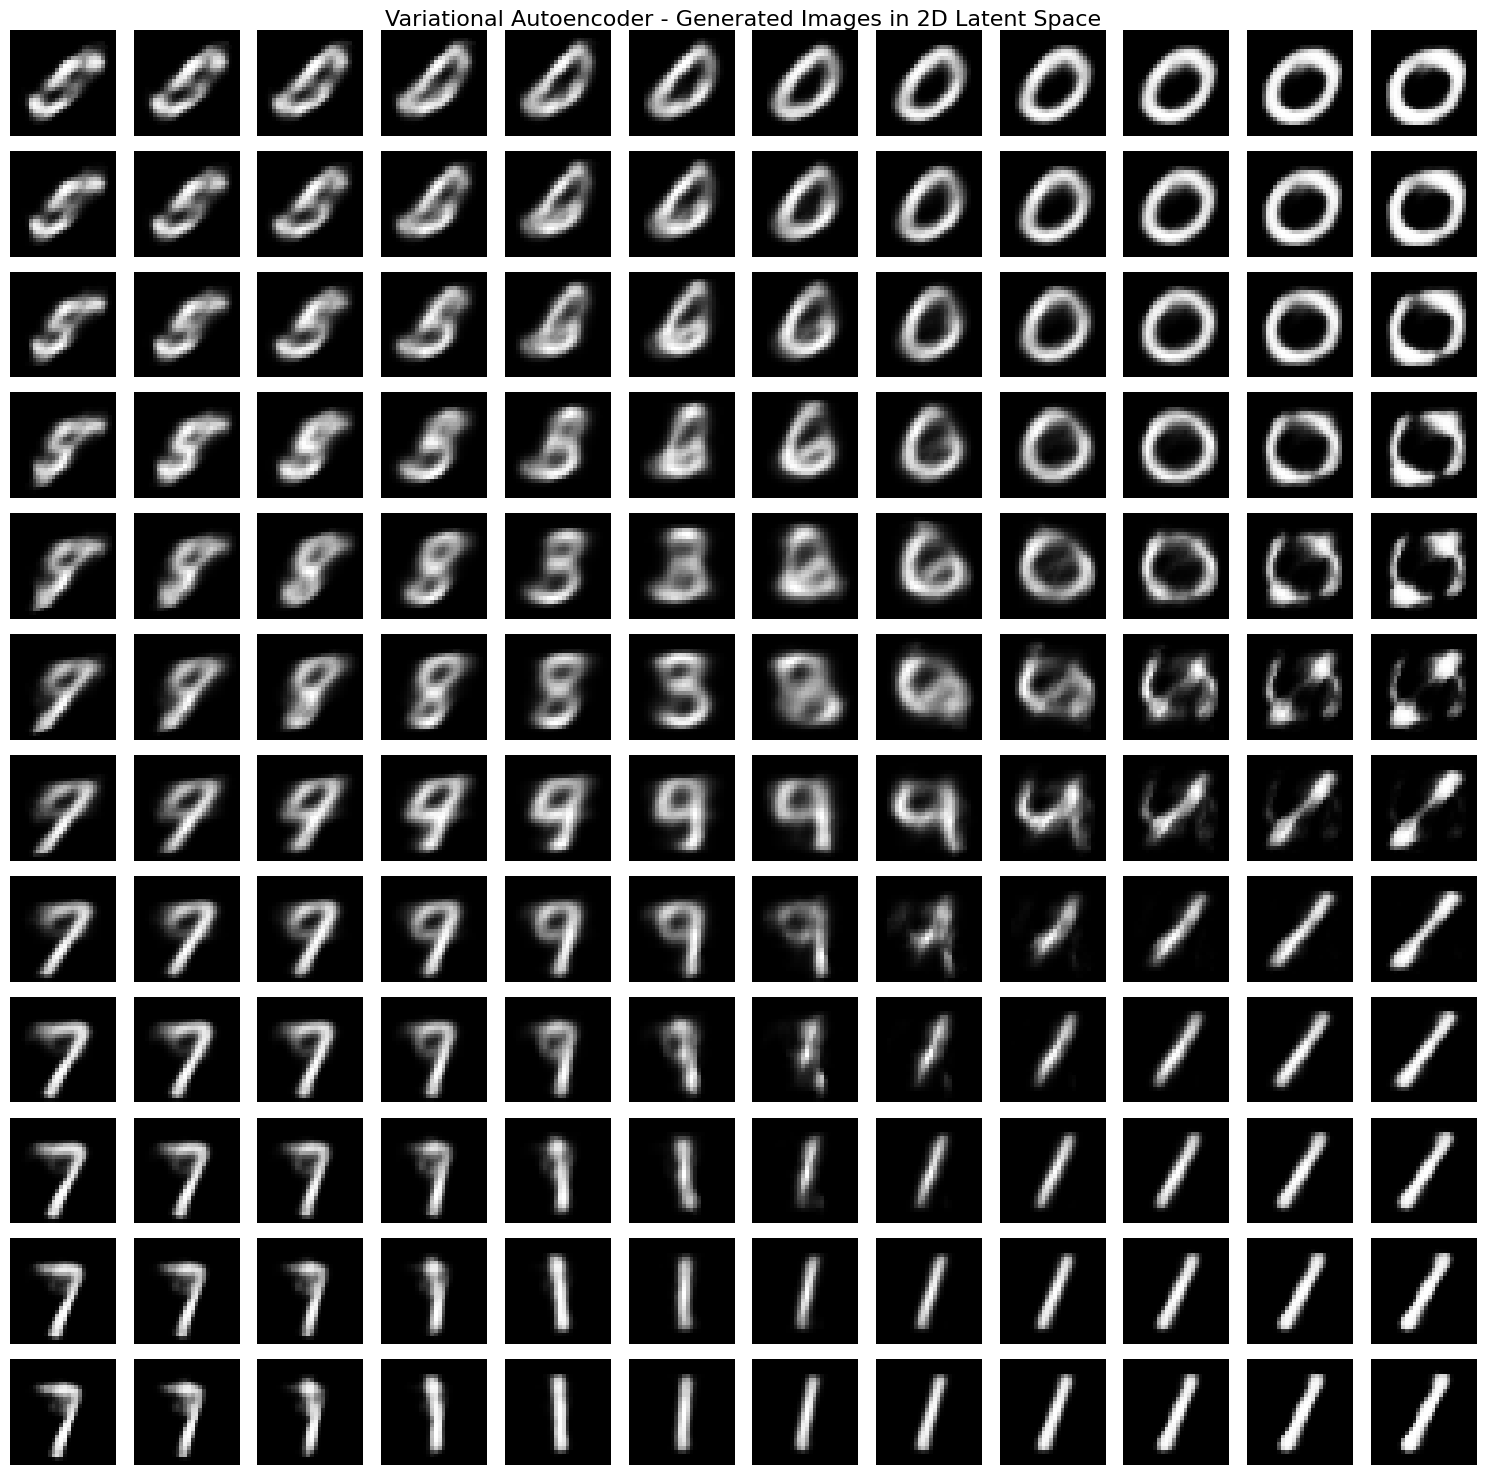

In [6]:
# Generate images in the 2D latent space
with torch.no_grad():
    # Define the grid in the 2D latent space
    n_samples_per_class = 12
    x_values = torch.linspace(-3, 3, n_samples_per_class)
    y_values = torch.linspace(-3, 3, n_samples_per_class)
    grid_x, grid_y = torch.meshgrid(x_values, y_values)
    z_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    # Decode the grid points to generate images
    generated_images = vae.decoder(z_grid).detach().numpy()

# Visualize the generated images in the 2D latent space
plt.figure(figsize=(15, 15))

image_size = 28
for i in range(generated_images.shape[0]):
    image = generated_images[i].reshape(image_size, image_size)

    ax = plt.subplot(n_samples_per_class, n_samples_per_class, i+1)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.suptitle("Variational Autoencoder - Generated Images in 2D Latent Space", fontsize=16)
plt.tight_layout()
plt.show()


# The loss function

The loss function for a Variational Autoencoder (VAE) consists of two main components: the reconstruction loss and the Kullback-Leibler (KL) divergence. These components work together to train the VAE to reconstruct the input data accurately while also regularizing the learned latent space distribution to match a prior distribution.

Reconstruction Loss:
The reconstruction loss measures the dissimilarity between the original input data and the reconstructed data produced by the VAE's decoder. It encourages the VAE to learn a meaningful latent representation that can faithfully reconstruct the input data. Typically, the reconstruction loss is computed using a pixel-wise error metric such as mean squared error (MSE) or binary cross-entropy (BCE), depending on the type of data.

Kullback-Leibler (KL) Divergence:
The KL divergence quantifies the difference between two probability distributions. In the case of VAEs, it measures the discrepancy between the learned latent space distribution and a prior distribution, usually a multivariate Gaussian distribution. The KL divergence encourages the VAE to shape the latent space distribution to match the desired prior distribution. By doing so, it helps regularize the learned representation and supports the generation of new data points from the latent space.

The total loss function for the VAE combines these two components:


**total_loss = reconstruction_loss + kl_loss**

The reconstruction loss encourages the VAE to produce accurate reconstructions, while the KL loss encourages the VAE to learn a latent space distribution that aligns with the prior distribution. The relative weighting of these two components can be adjusted using a hyperparameter to balance the reconstruction fidelity and regularization strength.

During training, the VAE aims to minimize this total loss function using gradient-based optimization techniques such as stochastic gradient descent (SGD) or Adam. By optimizing the loss function, the VAE learns to encode the input data into a meaningful latent space representation and generate new data samples by sampling from the latent space distribution.

It's important to note that the choice of loss function may vary depending on the specific application and type of data. Additionally, other regularization techniques or modifications to the loss function, such as incorporating additional terms for specific objectives, can be introduced to further enhance the VAE's performance.






# The reparameterization Trick

The reparameterization trick is a technique used in Variational Autoencoders (VAEs) to enable efficient gradient-based optimization during training. It is particularly useful when dealing with stochastic operations in the VAE's latent space.

In VAEs, the latent space is modeled as a probability distribution, typically a multivariate Gaussian distribution. During training, we need to sample latent space points to generate new data samples and compute the reconstruction loss and KL divergence. However, directly backpropagating through these stochastic samples is not feasible because the gradients cannot flow through random variables.

The reparameterization trick circumvents this issue by decoupling the randomness from the parameterization of the distribution. Instead of directly sampling from the distribution, we introduce a deterministic transformation that incorporates both the distribution parameters (mean and variance) and a noise term. By sampling the noise term from a fixed distribution, such as a standard Gaussian, we can obtain a stochastic sample that is differentiable with respect to the distribution parameters.

Specifically, let's consider a latent space point z that follows a Gaussian distribution with mean μ and standard deviation σ. The reparameterization trick rewrites z as:



**z = μ + σ * ε**

where ε is the noise term sampled from a fixed distribution (e.g., a standard Gaussian).

By reformulating the sampling process in this way, we can treat z as a deterministic function of the noise term ε and the distribution parameters μ and σ. Consequently, the gradients can flow through the deterministic path, allowing efficient backpropagation and gradient-based optimization.

During training, the VAE learns to optimize the distribution parameters μ and σ to shape the latent space distribution. The KL divergence term in the loss function encourages the learned distribution to align with a prior distribution, such as a standard Gaussian. The reparameterization trick enables us to compute gradients for these distribution parameters and update them using standard backpropagation algorithms.



# The manifold hypotheis again and VAE

Variational Autoencoders (VAEs) offer a framework that supports the manifold hypothesis by learning a lower-dimensional latent space representation that captures the essential structure of the data. VAEs consist of an encoder network, a decoder network, and a probabilistic modeling approach.

The encoder network maps the high-dimensional input data onto a lower-dimensional latent space. This latent space acts as a bottleneck where the data is compressed into a lower-dimensional representation. Despite this compression, the decoder network is designed to reconstruct the original input data from the latent space representation.

The ability of VAEs to accurately reconstruct the entire information from the compressed latent space is a crucial aspect. It demonstrates that the high-dimensional data can be effectively represented in a lower-dimensional subspace without significant loss of information. This observation supports the idea that the real data lies in a low-dimensional subspace or manifold embedded within the high-dimensional input space.

By imposing a prior distribution on the latent space, typically a multivariate Gaussian, VAEs encourage the learned distribution to follow a smooth and continuous structure. The smoothness of the latent space corresponds to the notion that similar data points in the input space are mapped to nearby points in the latent space. As a result, VAEs can effectively capture the underlying manifold structure of the data.

Through the latent space representation, VAEs enable smooth transitions and interpolation between different data points. By sampling from the latent space, new data points can be generated that respect the learned manifold structure. This capability further supports the idea that the data distribution is concentrated in a lower-dimensional subspace rather than being uniformly spread throughout the high-dimensional space.